In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import gzip

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

plt.style.use('default')
sns.set_palette("husl")

In [ ]:
def prepare_crop_dataset(raw_dataset):
    """
    Comprehensive preprocessing pipeline for crop yield dataset.

    This function handles categorical encoding and boolean feature conversion to prepare
    the dataset for machine learning algorithms.

    Parameters:
    -----------
    raw_dataset : pandas.DataFrame
        The original crop yield dataset containing both categorical and numerical features

    Returns:
    --------
    tuple: (processed_dataset, region_encoder, soil_encoder, crop_encoder, weather_encoder)
        - processed_dataset: DataFrame with encoded categorical variables
        - encoders: LabelEncoder objects for each categorical feature (for inverse transformation)
    """

    processed_dataset = raw_dataset.copy()


    processed_dataset['Fertilizer_Used'] = (
        processed_dataset['Fertilizer_Used']
        .astype(str)
        .str.upper()
        .map({'TRUE': 1, 'FALSE': 0})
    )

    processed_dataset['Irrigation_Used'] = (
        processed_dataset['Irrigation_Used']
        .astype(str)
        .str.upper()
        .map({'TRUE': 1, 'FALSE': 0})
    )

    region_label_encoder = LabelEncoder()
    processed_dataset['Region'] = region_label_encoder.fit_transform(processed_dataset['Region'])

    soil_type_encoder = LabelEncoder()
    processed_dataset['Soil_Type'] = soil_type_encoder.fit_transform(processed_dataset['Soil_Type'])

    crop_variety_encoder = LabelEncoder()
    processed_dataset['Crop'] = crop_variety_encoder.fit_transform(processed_dataset['Crop'])

    weather_condition_encoder = LabelEncoder()
    processed_dataset['Weather_Condition'] = weather_condition_encoder.fit_transform(processed_dataset['Weather_Condition'])

    return (
        processed_dataset,
        region_label_encoder,
        soil_type_encoder,
        crop_variety_encoder,
        weather_condition_encoder
    )


In [ ]:
def generate_data_visualizations(dataset_for_analysis):
    """
    Generate comprehensive visualizations to understand data patterns and relationships.

    This function creates multiple visualization types to explore:
    - Feature correlations
    - Relationships between environmental factors and yield
    - Weather condition impacts on crop performance

    Parameters:
    -----------
    dataset_for_analysis : pandas.DataFrame
        The original dataset with categorical variables (before encoding)
    """

    max_sample_size = min(1000, int(len(dataset_for_analysis) * 0.1))
    sampled_data_subset = dataset_for_analysis.sample(n=max_sample_size, random_state=42)


    plt.figure(figsize=(10, 6))
    numerical_features = dataset_for_analysis[
        ['Rainfall_mm', 'Temperature_Celsius', 'Days_to_Harvest', 'Yield_tons_per_hectare']
    ]
    correlation_matrix = numerical_features.corr()

    sns.heatmap(
        correlation_matrix,
        annot=True,
        cmap='coolwarm',
        fmt='.2f',
        center=0,
        square=True
    )
    plt.title('Correlation Matrix: Environmental Factors vs Crop Yield', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    sns.scatterplot(
        data=sampled_data_subset,
        x='Rainfall_mm',
        y='Yield_tons_per_hectare',
        hue='Crop',
        alpha=0.6,
        s=50
    )
    plt.title('Rainfall Impact on Crop Yield', fontweight='bold')
    plt.xlabel('Rainfall (mm)')
    plt.ylabel('Yield (tons/hectare)')

    plt.subplot(1, 3, 2)
    sns.scatterplot(
        data=sampled_data_subset,
        x='Temperature_Celsius',
        y='Yield_tons_per_hectare',
        hue='Crop',
        alpha=0.6,
        s=50
    )
    plt.title('Temperature Impact on Crop Yield', fontweight='bold')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Yield (tons/hectare)')

    plt.subplot(1, 3, 3)
    sns.scatterplot(
        data=sampled_data_subset,
        x='Days_to_Harvest',
        y='Yield_tons_per_hectare',
        hue='Crop',
        alpha=0.6,
        s=50
    )
    plt.title('Growing Period Impact on Yield', fontweight='bold')
    plt.xlabel('Days to Harvest')
    plt.ylabel('Yield (tons/hectare)')

    plt.tight_layout()
    plt.savefig('environmental_factor_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    weather_performance_stats = dataset_for_analysis.groupby('Weather_Condition').agg({
        'Yield_tons_per_hectare': 'mean',
        'Rainfall_mm': 'mean'
    }).reset_index()

    fig, primary_axis = plt.subplots(figsize=(10, 6))

    primary_axis.plot(
        weather_performance_stats['Weather_Condition'],
        weather_performance_stats['Yield_tons_per_hectare'],
        label='Average Yield',
        color='steelblue',
        marker='o',
        linewidth=2,
        markersize=8
    )
    primary_axis.set_xlabel('Weather Condition', fontweight='bold')
    primary_axis.set_ylabel('Average Yield (tons/hectare)', color='steelblue', fontweight='bold')
    primary_axis.tick_params(axis='y', labelcolor='steelblue')
    primary_axis.grid(True, alpha=0.3)

    secondary_axis = primary_axis.twinx()
    secondary_axis.plot(
        weather_performance_stats['Weather_Condition'],
        weather_performance_stats['Rainfall_mm'],
        label='Average Rainfall',
        color='darkorange',
        marker='s',
        linewidth=2,
        markersize=8
    )
    secondary_axis.set_ylabel('Average Rainfall (mm)', color='darkorange', fontweight='bold')
    secondary_axis.tick_params(axis='y', labelcolor='darkorange')

    plt.title('Crop Performance vs Weather Conditions', fontsize=14, fontweight='bold', pad=20)
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
    plt.tight_layout()
    plt.savefig('weather_performance_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [ ]:
def train_and_evaluate_prediction_models(feature_matrix, target_variable):
    """
    Train multiple regression models and evaluate their performance.

    This function implements a comprehensive ML pipeline including:
    - Data splitting for training and testing
    - Multiple algorithm training (Linear Regression, Decision Tree, Random Forest)
    - Performance evaluation and model comparison
    - Training progress visualization

    Parameters:
    -----------
    feature_matrix : pandas.DataFrame or numpy.array
        Input features for model training
    target_variable : pandas.Series or numpy.array
        Target variable (crop yield) for prediction

    Returns:
    --------
    tuple: (best_model_info, evaluation_results)
        - best_model_info: Dictionary containing the best performing model and its name
        - evaluation_results: Dictionary with performance metrics for all models
    """

    features_train, features_test, target_train, target_test = train_test_split(
        feature_matrix,
        target_variable,
        test_size=0.2,
        random_state=42
    )

    linear_regression_model = SGDRegressor(
        max_iter=1000,
        learning_rate="optimal",
        random_state=42,
        alpha=0.01 
    )

    training_loss_history = []
    convergence_iterations = 100

    for iteration in range(convergence_iterations):
        linear_regression_model.partial_fit(features_train, target_train)
        predictions_train = linear_regression_model.predict(features_train)
        current_loss = mean_squared_error(target_train, predictions_train)
        training_loss_history.append(current_loss)

    # Visualize training convergence
    plt.figure(figsize=(8, 5))
    plt.plot(
        range(1, convergence_iterations + 1),
        training_loss_history,
        label='Training Loss',
        marker='o',
        markersize=3,
        linestyle='-',
        color='crimson',
        linewidth=2
    )
    plt.xlabel("Training Iterations", fontweight='bold')
    plt.ylabel("Mean Squared Error", fontweight='bold')
    plt.title("Model Convergence: Linear Regression Training Progress", fontsize=12, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig('model_convergence_curve.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    decision_tree_model = DecisionTreeRegressor(
        max_depth=10,          
        min_samples_split=5,   
        min_samples_leaf=2,   
        random_state=42
    )
    decision_tree_model.fit(features_train, target_train)

    random_forest_model = RandomForestRegressor(
        n_estimators=100,      
        max_depth=10,           
        min_samples_split=5,    
        min_samples_leaf=2,     
        n_jobs=-1,              
        random_state=42,
        bootstrap=True         
    )
    random_forest_model.fit(features_train, target_train)


    predictions_linear = linear_regression_model.predict(features_test)
    predictions_decision_tree = decision_tree_model.predict(features_test)
    predictions_random_forest = random_forest_model.predict(features_test)


    model_performance_results = {}
    best_r2_score = -np.inf
    optimal_model = None
    optimal_model_name = ""

    model_predictions = [
        ('Linear Regression (SGD)', predictions_linear, linear_regression_model),
        ('Decision Tree Regressor', predictions_decision_tree, decision_tree_model),
        ('Random Forest Regressor', predictions_random_forest, random_forest_model)
    ]

    for model_name, model_predictions_test, trained_model in model_predictions:
        # Calculate comprehensive evaluation metrics
        mae_score = mean_absolute_error(target_test, model_predictions_test)
        mse_score = mean_squared_error(target_test, model_predictions_test)
        r2_coefficient = r2_score(target_test, model_predictions_test)
        rmse_score = np.sqrt(mse_score)  # Root Mean Square Error

        model_performance_results[model_name] = {
            'MAE': mae_score,
            'MSE': mse_score,
            'RMSE': rmse_score,
            'R2': r2_coefficient
        }

        if r2_coefficient > best_r2_score:
            best_r2_score = r2_coefficient
            optimal_model = trained_model
            optimal_model_name = model_name

    best_model_information = {
        'model': optimal_model,
        'model_name': optimal_model_name
    }

    return best_model_information, model_performance_results

In [ ]:
def generate_yield_prediction(trained_model_info, categorical_encoders, prediction_input):
    """
    Generate crop yield prediction for new input data using the trained model.

    This function handles the complete prediction pipeline including:
    - Input data preprocessing
    - Categorical variable encoding
    - Feature preparation
    - Model inference

    Parameters:
    -----------
    trained_model_info : dict
        Dictionary containing the trained model and metadata
    categorical_encoders : tuple
        Tuple of fitted LabelEncoder objects for categorical features
    prediction_input : dict or pandas.DataFrame
        Input data for prediction containing all required features

    Returns:
    --------
    float: Predicted crop yield in tons per hectare
    """

    prediction_model = trained_model_info['model']
    region_encoder, soil_encoder, crop_encoder, weather_encoder = categorical_encoders


    if not isinstance(prediction_input, pd.DataFrame):
        prediction_input = pd.DataFrame([prediction_input])

    processed_input = prediction_input.copy()


    processed_input['Region'] = region_encoder.transform(processed_input['Region'])
    processed_input['Soil_Type'] = soil_encoder.transform(processed_input['Soil_Type'])
    processed_input['Crop'] = crop_encoder.transform(processed_input['Crop'])
    processed_input['Weather_Condition'] = weather_encoder.transform(processed_input['Weather_Condition'])


    processed_input['Fertilizer_Used'] = (
        processed_input['Fertilizer_Used']
        .astype(str)
        .str.upper()
        .map({'TRUE': 1, 'FALSE': 0})
    )

    processed_input['Irrigation_Used'] = (
        processed_input['Irrigation_Used']
        .astype(str)
        .str.upper()
        .map({'TRUE': 1, 'FALSE': 0})
    )


    feature_columns = [
        'Region', 'Soil_Type', 'Crop', 'Rainfall_mm', 'Temperature_Celsius',
        'Fertilizer_Used', 'Irrigation_Used', 'Weather_Condition', 'Days_to_Harvest'
    ]
    prediction_features = processed_input[feature_columns]


    yield_prediction = prediction_model.predict(prediction_features)

    return yield_prediction[0]

CROP YIELD PREDICTION ANALYSIS PIPELINE

1. Loading and validating dataset...
   ✓ Successfully loaded 1000000 records
   ✓ Dataset shape: (1000000, 10)

2. Generating exploratory data analysis visualizations...


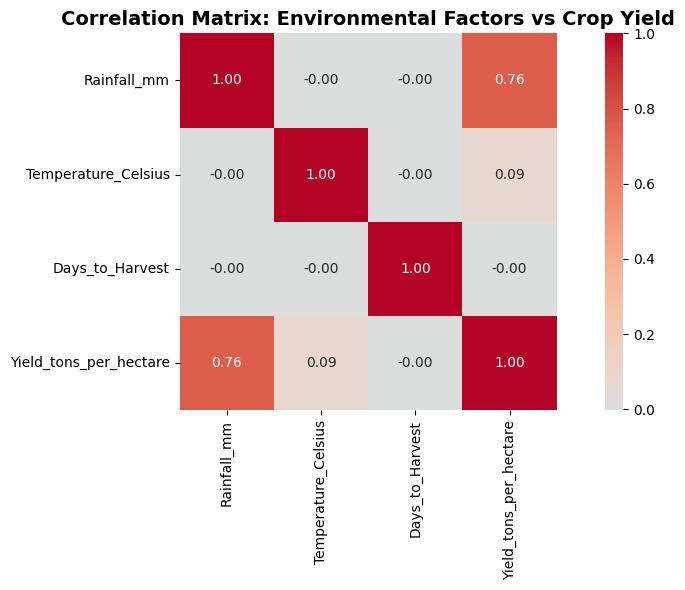

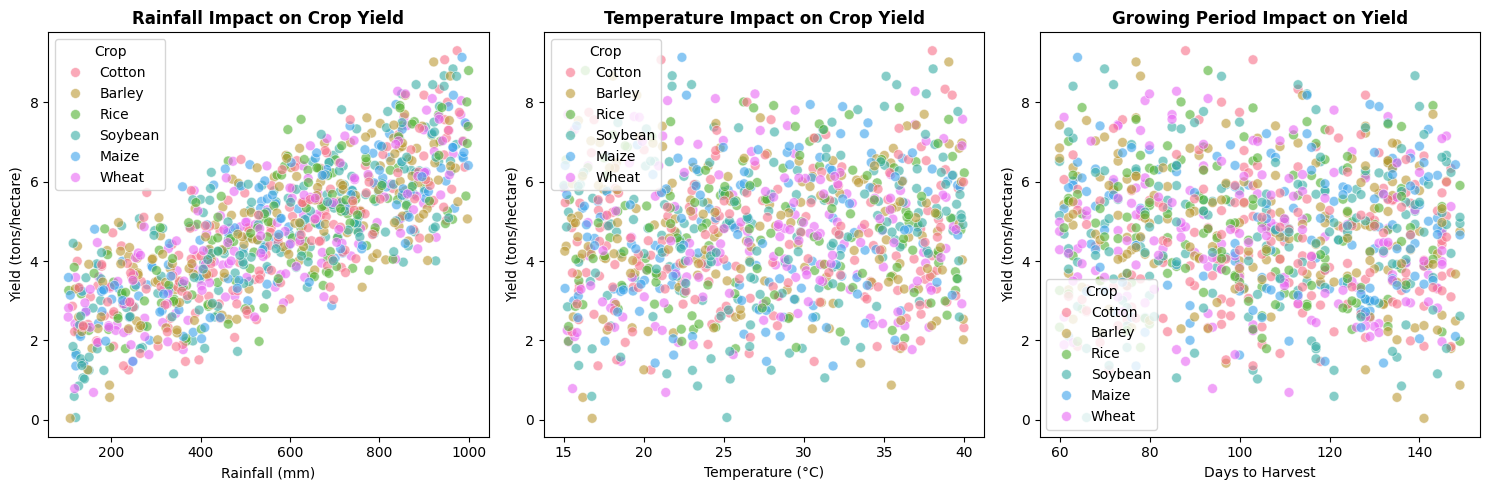

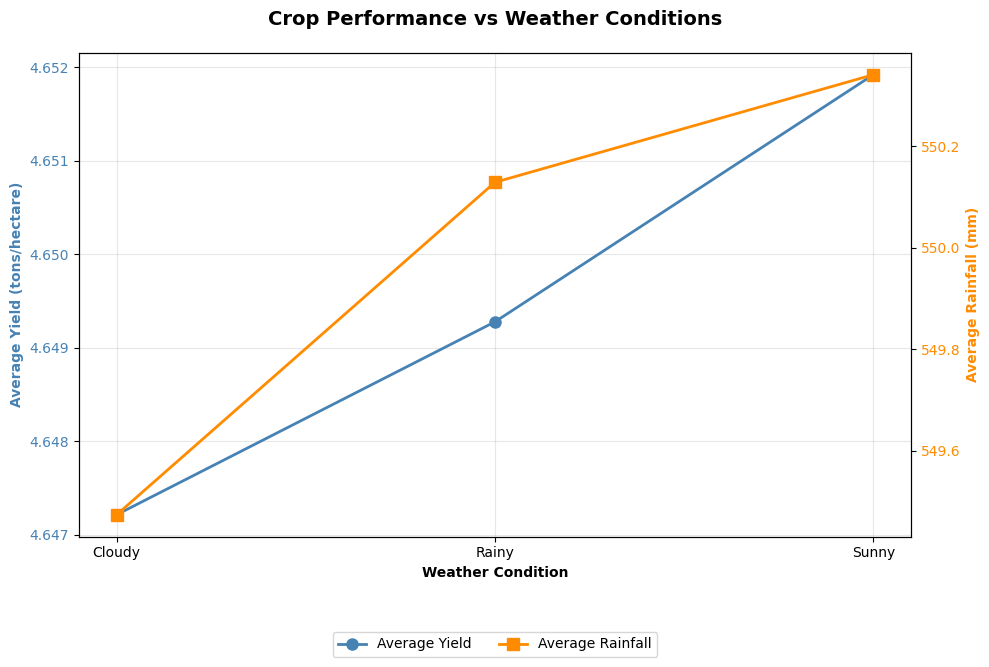

   ✓ Correlation heatmap saved as 'correlation_heatmap.png'
   ✓ Environmental factor analysis saved as 'environmental_factor_analysis.png'
   ✓ Weather performance analysis saved as 'weather_performance_analysis.png'

3. Preprocessing dataset for machine learning...
   ✓ Categorical variables encoded successfully
   ✓ Boolean features converted to binary format

4. Preparing features and target variables...
   ✓ Feature matrix shape: (1000000, 9)
   ✓ Target variable shape: (1000000,)

5. Training and evaluating machine learning models...


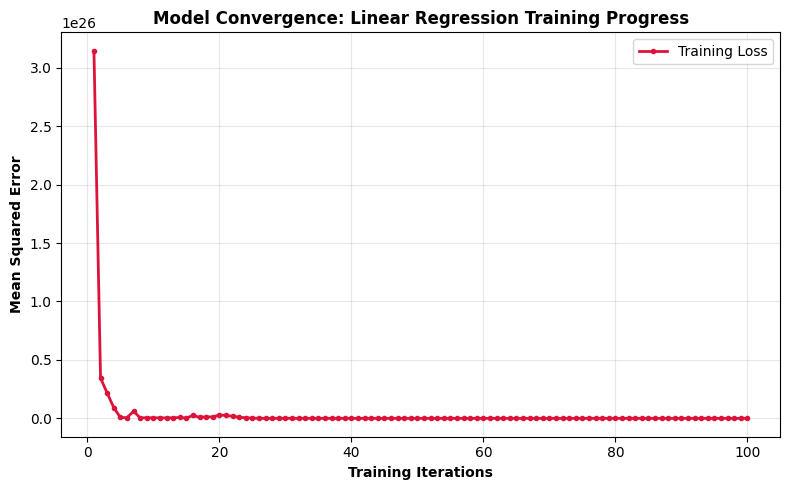

   ✓ Model convergence curve saved as 'model_convergence_curve.png'

MODEL PERFORMANCE EVALUATION RESULTS

Linear Regression (SGD):
  • Mean Absolute Error (MAE):  8171353503.0921
  • Mean Squared Error (MSE):   96448243253690449920.0000
  • Root Mean Squared Error:    9820806649.8476
  • R² Score (Coefficient):     -33454742940714536960.0000

Decision Tree Regressor:
  • Mean Absolute Error (MAE):  0.4018
  • Mean Squared Error (MSE):   0.2537
  • Root Mean Squared Error:    0.5037
  • R² Score (Coefficient):     0.9120

Random Forest Regressor:
  • Mean Absolute Error (MAE):  0.4002
  • Mean Squared Error (MSE):   0.2516
  • Root Mean Squared Error:    0.5016
  • R² Score (Coefficient):     0.9127

🏆 BEST PERFORMING MODEL: Random Forest Regressor

6. Saving trained model and encoders...
   ✓ Model saved as 'optimal_crop_yield_model.pkl'
   ✓ Compressed model saved as 'optimal_crop_yield_model.pkl.gz'

7. Demonstrating prediction capability...
   Sample Input Data: {'Region': 'West', 

C:\Users\Manzi\AppData\Local\Temp\ipykernel_2576\4069279005.py:163: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


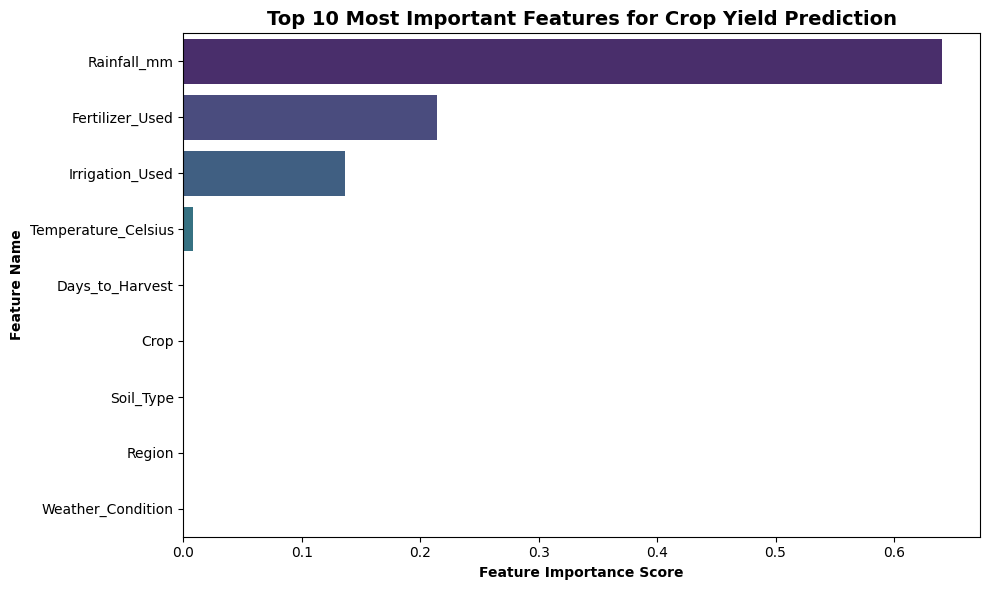

   ✓ Feature importance chart saved as 'feature_importance_analysis.png'

   TOP 10 MOST IMPORTANT FEATURES:
    4. Rainfall_mm          - 0.6407
    6. Fertilizer_Used      - 0.2142
    7. Irrigation_Used      - 0.1366
    5. Temperature_Celsius  - 0.0084
    9. Days_to_Harvest      - 0.0001
    3. Crop                 - 0.0000
    2. Soil_Type            - 0.0000
    1. Region               - 0.0000
    8. Weather_Condition    - 0.0000

✅ CROP YIELD PREDICTION PIPELINE COMPLETED SUCCESSFULLY!

Generated Files:
• correlation_heatmap.png - Feature correlation analysis
• environmental_factor_analysis.png - Environmental impact visualization
• weather_performance_analysis.png - Weather condition analysis
• model_convergence_curve.png - Training progress visualization
• optimal_crop_yield_model.pkl - Trained model (uncompressed)
• optimal_crop_yield_model.pkl.gz - Trained model (compressed)
• feature_importance_analysis.png - Feature importance ranking

Best Model: Random Forest Regressor

In [ ]:
if __name__ == "__main__":
    print("="*60)
    print("CROP YIELD PREDICTION ANALYSIS PIPELINE")
    print("="*60)

    print("\n1. Loading and validating dataset...")

    try:
        crop_yield_dataset = pd.read_csv(
            'crop_yield.csv',
            dtype={'Fertilizer_Used': 'object', 'Irrigation_Used': 'object'}
        )
        print(f"   ✓ Successfully loaded {len(crop_yield_dataset)} records")
        print(f"   ✓ Dataset shape: {crop_yield_dataset.shape}")

    except FileNotFoundError:
        print("   ✗ Error: 'crop_yield.csv' file not found!")
        print("   Please ensure the dataset file is in the current directory.")
        exit(1)

    print("\n2. Generating exploratory data analysis visualizations...")

    generate_data_visualizations(crop_yield_dataset)
    print("   ✓ Correlation heatmap saved as 'correlation_heatmap.png'")
    print("   ✓ Environmental factor analysis saved as 'environmental_factor_analysis.png'")
    print("   ✓ Weather performance analysis saved as 'weather_performance_analysis.png'")

    print("\n3. Preprocessing dataset for machine learning...")

    (processed_crop_data,
     region_encoder,
     soil_encoder,
     crop_encoder,
     weather_encoder) = prepare_crop_dataset(crop_yield_dataset.copy())

    print("   ✓ Categorical variables encoded successfully")
    print("   ✓ Boolean features converted to binary format")

    print("\n4. Preparing features and target variables...")

    feature_column_names = [
        'Region', 'Soil_Type', 'Crop', 'Rainfall_mm', 'Temperature_Celsius',
        'Fertilizer_Used', 'Irrigation_Used', 'Weather_Condition', 'Days_to_Harvest'
    ]

    independent_variables = processed_crop_data[feature_column_names]
    dependent_variable = processed_crop_data['Yield_tons_per_hectare']

    print(f"   ✓ Feature matrix shape: {independent_variables.shape}")
    print(f"   ✓ Target variable shape: {dependent_variable.shape}")

    print("\n5. Training and evaluating machine learning models...")

    best_model_info, model_evaluation_results = train_and_evaluate_prediction_models(
        independent_variables,
        dependent_variable
    )

    print("   ✓ Model convergence curve saved as 'model_convergence_curve.png'")

    print("\n" + "="*50)
    print("MODEL PERFORMANCE EVALUATION RESULTS")
    print("="*50)

    for model_name, performance_metrics in model_evaluation_results.items():
        print(f"\n{model_name}:")
        print(f"  • Mean Absolute Error (MAE):  {performance_metrics['MAE']:.4f}")
        print(f"  • Mean Squared Error (MSE):   {performance_metrics['MSE']:.4f}")
        print(f"  • Root Mean Squared Error:    {performance_metrics['RMSE']:.4f}")
        print(f"  • R² Score (Coefficient):     {performance_metrics['R2']:.4f}")

    print(f"\n🏆 BEST PERFORMING MODEL: {best_model_info['model_name']}")

    print("\n6. Saving trained model and encoders...")

    model_package = {
        'model': best_model_info['model'],
        'model_name': best_model_info['model_name'],
        'region_encoder': region_encoder,
        'soil_encoder': soil_encoder,
        'crop_encoder': crop_encoder,
        'weather_encoder': weather_encoder,
        'feature_columns': feature_column_names,
        'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
    }

    with open("optimal_crop_yield_model.pkl", "wb") as model_file:
        pickle.dump(model_package, model_file)

    with open("optimal_crop_yield_model.pkl", "rb") as input_file:
        with gzip.open("optimal_crop_yield_model.pkl.gz", "wb") as compressed_file:
            compressed_file.writelines(input_file)

    print("   ✓ Model saved as 'optimal_crop_yield_model.pkl'")
    print("   ✓ Compressed model saved as 'optimal_crop_yield_model.pkl.gz'")

    print("\n7. Demonstrating prediction capability...")

    sample_prediction_data = crop_yield_dataset.drop('Yield_tons_per_hectare', axis=1).iloc[0].to_dict()
    actual_yield = crop_yield_dataset.iloc[0]['Yield_tons_per_hectare']

    encoder_collection = (region_encoder, soil_encoder, crop_encoder, weather_encoder)

    predicted_yield_value = generate_yield_prediction(
        best_model_info,
        encoder_collection,
        sample_prediction_data
    )

    print(f"   Sample Input Data: {sample_prediction_data}")
    print(f"   🎯 Predicted Yield: {predicted_yield_value:.2f} tons per hectare")
    print(f"   📊 Actual Yield: {actual_yield:.2f} tons per hectare")
    print(f"   📈 Prediction Error: {abs(predicted_yield_value - actual_yield):.2f} tons per hectare")

    print("\n8. Analyzing feature importance...")

    if isinstance(best_model_info['model'], RandomForestRegressor):
        feature_importance_data = pd.DataFrame({
            'feature_name': independent_variables.columns,
            'importance_score': best_model_info['model'].feature_importances_
        }).sort_values('importance_score', ascending=False)

        # Create feature importance visualization
        plt.figure(figsize=(10, 6))
        sns.barplot(
            data=feature_importance_data.head(10),
            x='importance_score',
            y='feature_name',
            palette='viridis'
        )
        plt.title('Top 10 Most Important Features for Crop Yield Prediction',
                 fontsize=14, fontweight='bold')
        plt.xlabel('Feature Importance Score', fontweight='bold')
        plt.ylabel('Feature Name', fontweight='bold')
        plt.tight_layout()
        plt.savefig('feature_importance_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("   ✓ Feature importance chart saved as 'feature_importance_analysis.png'")
        print("\n   TOP 10 MOST IMPORTANT FEATURES:")
        for idx, row in feature_importance_data.head(10).iterrows():
            print(f"   {row.name + 1:2d}. {row['feature_name']:<20} - {row['importance_score']:.4f}")

    else:
        print("   ℹ️  Feature importance analysis only available for Random Forest models")

    print("\n" + "="*60)
    print("✅ CROP YIELD PREDICTION PIPELINE COMPLETED SUCCESSFULLY!")
    print("="*60)
    print("\nGenerated Files:")
    print("• correlation_heatmap.png - Feature correlation analysis")
    print("• environmental_factor_analysis.png - Environmental impact visualization")
    print("• weather_performance_analysis.png - Weather condition analysis")
    print("• model_convergence_curve.png - Training progress visualization")
    print("• optimal_crop_yield_model.pkl - Trained model (uncompressed)")
    print("• optimal_crop_yield_model.pkl.gz - Trained model (compressed)")
    if isinstance(best_model_info['model'], RandomForestRegressor):
        print("• feature_importance_analysis.png - Feature importance ranking")

    print(f"\nBest Model: {best_model_info['model_name']}")
    print(f"Model R² Score: {model_evaluation_results[best_model_info['model_name']]['R2']:.4f}")
    print("\nThe model is ready for production use! 🚀")